In [1]:
import numpy as np
import cv2
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
import random
from tensorflow.keras import layers

In [20]:
## input and output
input_dir = 'E:/3Dimage/Intensity/OCT_Pupillary_Test/corneadata/input/'
target_dir = 'E:/3Dimage/Intensity/OCT_Pupillary_Test/corneadata/output/'

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg") and not fname.startswith(".")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".jpg") and not fname.startswith(".")
    ]
)
print("Number of samples:", len(input_img_paths))
for input_path, target_path in zip(input_img_paths[450:460], target_img_paths[450:460]):
    print(input_path, "|", target_path)

Number of samples: 699
E:/3Dimage/Intensity/OCT_Pupillary_Test/corneadata/input/input_507.jpg | E:/3Dimage/Intensity/OCT_Pupillary_Test/corneadata/output/output_507.jpg
E:/3Dimage/Intensity/OCT_Pupillary_Test/corneadata/input/input_508.jpg | E:/3Dimage/Intensity/OCT_Pupillary_Test/corneadata/output/output_508.jpg
E:/3Dimage/Intensity/OCT_Pupillary_Test/corneadata/input/input_509.jpg | E:/3Dimage/Intensity/OCT_Pupillary_Test/corneadata/output/output_509.jpg
E:/3Dimage/Intensity/OCT_Pupillary_Test/corneadata/input/input_51.jpg | E:/3Dimage/Intensity/OCT_Pupillary_Test/corneadata/output/output_51.jpg
E:/3Dimage/Intensity/OCT_Pupillary_Test/corneadata/input/input_510.jpg | E:/3Dimage/Intensity/OCT_Pupillary_Test/corneadata/output/output_510.jpg
E:/3Dimage/Intensity/OCT_Pupillary_Test/corneadata/input/input_511.jpg | E:/3Dimage/Intensity/OCT_Pupillary_Test/corneadata/output/output_511.jpg
E:/3Dimage/Intensity/OCT_Pupillary_Test/corneadata/input/input_512.jpg | E:/3Dimage/Intensity/OCT_Pupil

In [29]:
#image augmentation

seed_num = 0
resize_and_rescale = tf.keras.Sequential([
  layers.Rescaling(1./225),
  layers.Resizing(512, 512),
  layers.RandomContrast(factor = [0.5, 1.3]),
  layers.RandomFlip(seed=seed_num),
  layers.RandomRotation(seed=seed_num, factor=(-0.05, 0.05), fill_mode = "nearest"),
  layers.RandomZoom(seed=seed_num, height_factor=(-0.1, 0))
  #layers.Lambda(random_flip_on_probability)
])
resize_and_rescale_mask = tf.keras.Sequential([
  layers.Resizing(512, 512),
  layers.RandomFlip(seed=seed_num),
  layers.RandomRotation(seed=seed_num, factor=(-0.05, 0.05), fill_mode = "nearest"),
  layers.RandomZoom(seed=seed_num, height_factor=(-0.1, 0))
])

#display
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['original Image', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

#create mask
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask
#test 
test_resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(512, 512),
  layers.Rescaling(1./225),
])

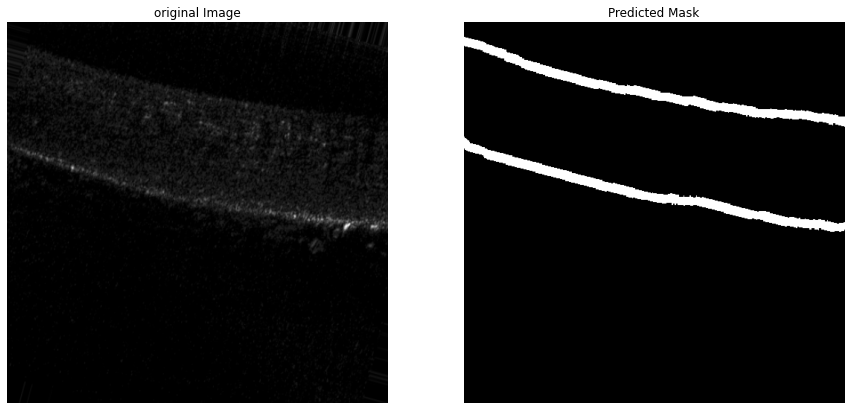

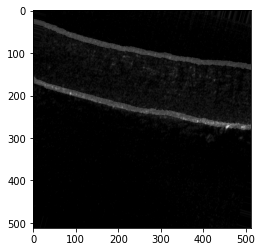

In [16]:
#need to make sure that the input pipeline produce the correct input image and its corresponding mask
i = 550
batch_size = 10
img_size = (512, 512)
seed_num = random.randrange(0, 100)
batch_input_img_paths = input_img_paths[i : i + batch_size]
batch_target_img_paths = target_img_paths[i : i + batch_size]
x = np.zeros((batch_size,) + img_size + (3,), dtype="float32")
for j, path in enumerate(batch_input_img_paths):
    img = cv2.imread(path)
    img = resize_and_rescale(img)
    x[j] = img
y = np.zeros((batch_size,) + img_size + (3,), dtype="uint8")
for j, path in enumerate(batch_target_img_paths):
    #img = load_img(path, target_size= img_size, color_mode="grayscale")
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img = np.repeat(np.expand_dims(img,-1),3,-1)
    #img = (img/np.max(img)*225).astype(np.uint8)
    #img = cv2.resize(img, (512, 512))
    img = resize_and_rescale_mask(img)
    y[j] = img
    ## Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
    ##y[j] -= 1
#y = np.expand_dims(y, -1)
y = y[:, :, :, 0]
m = 5
display([x[m], np.repeat(np.expand_dims(y[m],-1),3,-1)])
#display([x[0], y[0]])
#combine image
#add_image = cv2.addWeighted(tf.keras.utils.array_to_img(x[1]), 0.6, tf.keras.utils.array_to_img(np.repeat(np.expand_dims(y[1],-1),3,-1)), 0.2, 0)
plt.imshow(tf.keras.utils.array_to_img(x[m]), cmap = "gray")
plt.imshow(tf.keras.utils.array_to_img(np.repeat(np.expand_dims(y[m],-1),3,-1)), cmap = "jet", alpha = 0.2)
## always test new code before implementing it. Sometimes no errors doesn't mean no errors

In [50]:
#mask1 = y[0]
#np.unique(mask1)
#np.max(mask1)


img = cv2.imread(batch_input_img_paths[3])
img = resize_and_rescale(img)
#[np.max(img[:, :, 0]), np.max(img[:, :, 1]), np.max(img[:, :, 2])]
[np.max(img[:, :, 0]), np.max(img[:, :, 1]), np.max(img[:, :, 2])]
print("Min and max pixel values:", img.numpy().min(), img.numpy().max())


Min and max pixel values: -0.007865053 0.85157347


In [18]:
#construct CNN model 
base_model = tf.keras.applications.MobileNetV2(input_shape=[512, 512, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

#decoder/upsampler
from tensorflow_examples.models.pix2pix import pix2pix
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[512, 512, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

#Compile the model

OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

tf.keras.utils.plot_model(model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [19]:
#input pipeline

class Cornea_input(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        ##Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        seed_num = random.randrange(0, 100)
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = cv2.imread(path)
            img = resize_and_rescale(img)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
            img = np.repeat(np.expand_dims(img,-1),3,-1)
            #img = (img/np.max(img)*225).astype(np.uint8)
            #img = cv2.resize(img, (512, 512))
            img = resize_and_rescale_mask(img)
            y[j] = img
        y = y[:, :, :, 0]

        x, y, weights = self.add_sample_weights(x, y)
        return x, y, weights
    
    def add_sample_weights(self, image, label):
        # The weights for each class, with the constraint that:
        #     sum(class_weights) == 1.0
        class_weights = tf.constant([1.0, 2.0, 0.0])
        class_weights = class_weights/tf.reduce_sum(class_weights)

        # Create an image of `sample_weights` by using the label at each pixel as an 
        # index into the `class weights` .
        sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

        return image, label, sample_weights
    

In [21]:
# Split our img paths into a training and a validation set
val_samples = int(len(input_img_paths) * 0.2)
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = Cornea_input(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = Cornea_input(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [23]:
model_history = model.fit(train_gen,
                         epochs=5,
                         #initial_epoch=history_fine.epoch[-1],
                         validation_data=val_gen)

Epoch 1/5
56/56 [==============================] - 106s 2s/step - loss: 0.0214 - accuracy: 0.9810 - val_loss: 0.0251 - val_accuracy: 0.9795
Epoch 2/5
56/56 [==============================] - 106s 2s/step - loss: 0.0210 - accuracy: 0.9813 - val_loss: 0.0238 - val_accuracy: 0.9778
Epoch 3/5
56/56 [==============================] - 105s 2s/step - loss: 0.0207 - accuracy: 0.9815 - val_loss: 0.0236 - val_accuracy: 0.9802
Epoch 4/5
56/56 [==============================] - 106s 2s/step - loss: 0.0198 - accuracy: 0.9821 - val_loss: 0.0220 - val_accuracy: 0.9807
Epoch 5/5
56/56 [==============================] - 110s 2s/step - loss: 0.0193 - accuracy: 0.9821 - val_loss: 0.0220 - val_accuracy: 0.9795


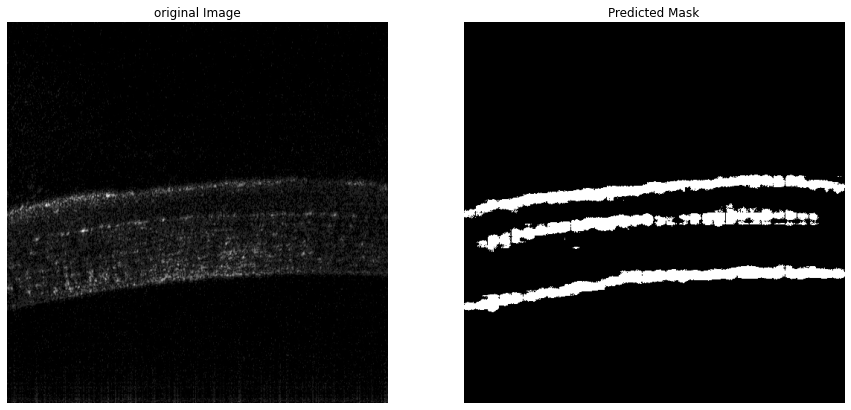

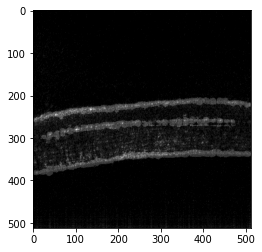

In [97]:
index = 250
img = cv2.imread(input_img_paths[index])
#img = (img/np.max(img)*225).astype(np.uint8)
img = test_resize_and_rescale(img)
predict_mask = model.predict(np.expand_dims(img, 0))
display([img, np.repeat(create_mask(predict_mask[0]),3,-1)])
plt.imshow(tf.keras.utils.array_to_img(img), cmap = "gray")
plt.imshow(tf.keras.utils.array_to_img(np.repeat(create_mask(predict_mask[0]),3,-1)), cmap = "jet", alpha = 0.2)

In [42]:
model.save('saved_model/cornea_model')

INFO:tensorflow:Assets written to: saved_model/cornea_model\assets


E:\Xiao_Liu\python\ML_envn\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
E:\Xiao_Liu\python\ML_envn\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
